Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
╒════════════════════════════════════════════════════════════╤═══════════╤════════════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                                                       │ class     │ transform              │ prior   │ trainable   │ shape   │ dtype   │     value │
╞════════════════════════════════════════════════════════════╪═══════════╪════════

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
╒═══════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                                          │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═══════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ ContinuousModel.models[0].kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.601705 │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ ContinuousModel

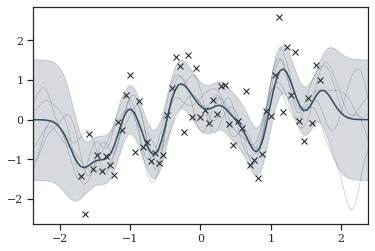

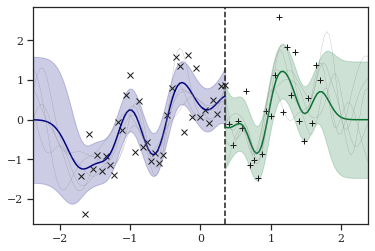

L: -68.68471609059085, k: 14, N: 59
L: -72.57903487542936, k: 7, N: 59
Log bayes factor:  -10.377062268831523
log marginal likelihoods:
	continuous model: -72.57903487542936
	discontinuous control model: -40.19686101960801
	discontinuous intervention model: -28.487855070982853


In [27]:
import gpflow
f64 = gpflow.utilities.to_default_float
from gpflow.kernels import *
import BNQD
import numpy as np
import matplotlib.pyplot as plt
import csv
from bnqdflow import models, base, effect_size_measures, util, analyses
import scipy.stats as stats
import os
import warnings
import importlib
import toolbox as t
from SpectralMixture import SpectralMixture

warnings.simplefilter('ignore')
importlib.reload(BNQD)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Hide tensorflow warnings.
np.random.seed(1)

# # Create synthetic data
# N = 50
# b = 0.5
# n_samples_prior = 5
# n_samples_posterior = 40
# X = np.random.rand(N,1) * 2 - 1
# Y = t.sinc_mean_function(X) + np.random.randn(N,1)*0.1
#
# # Generate test points for prediction
# xlim = [-1,1]
# xx = np.linspace(xlim[0], xlim[1], 1000).reshape(1000, 1)  # (N, D)
# mu = t.sinc_mean_function(xx)
# t.plot_data(X, Y, xx, mu)


datafile = 'datasets/Sicily smoking ban/sicily.csv'
data = dict()

with open(datafile, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        for k, v in dict(row).items():
            if k in data:
                data[k].append(v)
            else:
                data[k] = [v]

data['year']    = np.array([int(y) for y in data['year']])
data['month']   = np.array([int(m) for m in data['month']])
data['aces']    = np.array([int(a) for a in data['aces']]) # acute coronary events
data['time']    = np.array([int(t) for t in data['time']]) # predictor
data['smokban'] = np.array([s=='1' for s in data['smokban']])
data['pop']     = np.array([float(t) for t in data['pop']])
data['stdpop']  = np.array([float(st) for st in data['stdpop']]) # age-standardized population numbers

# Some transformations, needed to keep kernel matrices positive definite with reasonable parameter estimates.
# We simply transform back and forth when necessary.
zscorex = lambda x: (x - np.mean(data['time'])) / np.std(data['time'])
zscorey = lambda x: (x - np.mean(aces_per_agestd_pop)) / np.std(aces_per_agestd_pop)
inv_zscorey = lambda z: z*np.std(aces_per_agestd_pop) + np.mean(aces_per_agestd_pop)

n = len(data['time'])
b = data['time'][data['smokban']][0] - 1 # the ban instantiated *before* this
bz = zscorex(b)

labelFunc = lambda x: x < bz

aces_per_agestd_pop = data['aces'] / data['stdpop']*10**5
x = zscorex(data['time']).reshape(n,1)
y = stats.zscore(aces_per_agestd_pop).reshape(n,1) # ACE / age-standardized population
xx = np.linspace(x[0], x[-1], num=100).reshape(100, 1)  # interpolate between actual observations
#t.plot_data(data['time'], aces_per_agestd_pop, xx, b=b)

# Data used by the control model (pre-intervention)
x1 = x[x <= bz]
y1 = y[x <= bz]

# Data used by the (post-)intervention model
x2 = x[x > bz]
y2 = y[x > bz]

x_samples = np.linspace(-5, 5, 100)
x_samples1 = x_samples[x_samples <= bz]
x_samples2 = x_samples[x_samples > bz]

# Define kernels
Q               = 2 #t.find_optimal_Q(x, y, min_Q=1, max_Q=8, max_length=10., plot_BIC_scores=True)
max_freq        = 1.5 * 2 * np.pi
max_length      = 5.

sm              = SpectralMixture(Q=Q, max_length=max_length, max_freq=max_freq)

# Define training parameters
data =  [(x1, y1), (x2, y2)]
padding = 0.2

a = analyses.SimpleAnalysis([(x1, y1), (x2, y2)], sm, bz, share_params=False)
#a = analyses.SimpleAnalysis([(x1, y1), (x2, y2)], SquaredExponential()*Periodic(SquaredExponential()), bz, share_params=False)
a_se = analyses.SimpleAnalysis([(x1, y1), (x2, y2)], SquaredExponential(lengthscales=.2), bz, share_params=False)

a.train(verbose=True)
a_se.train(verbose=True)
a_se.plot_regressions()
log_bayes_factor = a.log_bayes_factor(verbose=False)
print('Log bayes factor: ', log_bayes_factor.numpy())

cm = a.continuous_model.model
dm = a.discontinuous_model
dcm = a.discontinuous_model.control_model
dim = a.discontinuous_model.intervention_model
print("log marginal likelihoods:\n\tcontinuous model: {}\n\tdiscontinuous control model: {}\n"
      "\tdiscontinuous intervention model: {}"
      .format(cm.maximum_log_likelihood_objective(), dcm.maximum_log_likelihood_objective(), dim.maximum_log_likelihood_objective()))


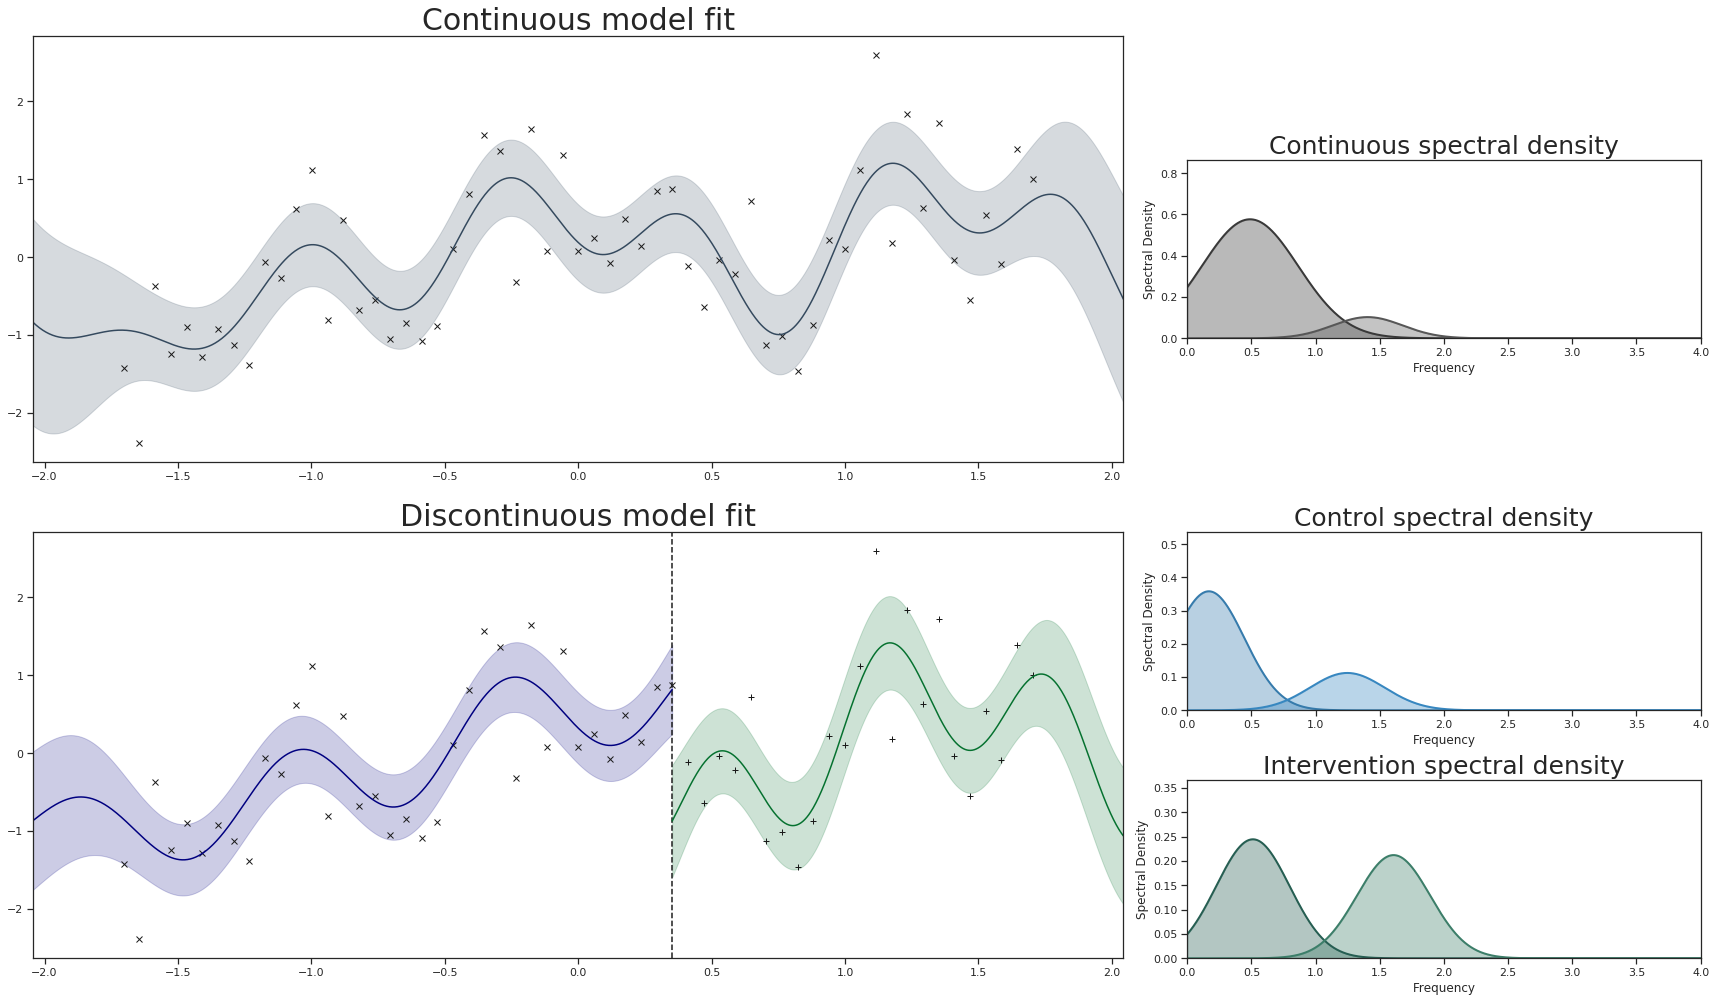

In [28]:
# Plot results
t.plot_posterior_model_spectrum(a, Q, padding=0.1,max_x = 4,scalar=1/np.std(x),xticks=None,yticks=None)
#plt.savefig('/home/david/Documenten/Courses/Thesis/Figures/Russian Suicide ITS/MAP_estimates.pdf',dpi=400)
plt.show()